In [1]:
from dataset import COCOSegmentation
import utils
import torch


/opt/anaconda3/envs/licenta/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dataset_test = COCOSegmentation(split='train', my_transforms=True)
classes = ['dent', 'scratch', 'crack', 'glass_shatter', 'lamp_broken', 'tire_flat']
sample = dataset_test[34]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Image 000387.jpg has labesls: tensor([4])


/Users/dragos/Licenta/Thesis/dataset.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  masks = Mask(torch.as_tensor(masks, dtype=torch.uint8))


In [3]:
num_classes = 6
device = torch.device('mps')
model = utils.get_model_instance_segmentation(num_classes)
model.load_state_dict(torch.load("/Users/dragos/Licenta/Results/Test1/epoch0.pth", map_location='mps'))
model.to(device)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [4]:
input = sample[0].to(device)
pred = model([input, ])

In [5]:
print(pred[0]['scores'])

pred = pred[0]

tensor([0.1819, 0.1653, 0.1651, 0.1600, 0.1572], device='mps:0',
       grad_fn=<IndexBackward0>)


In [11]:
score_mask = pred['scores'] > 0.17

filtered_prediction = {
    'masks': pred['masks'][score_mask],
    'boxes': pred['boxes'][score_mask],
    'labels': pred['labels'][score_mask]
}

In [12]:
print(filtered_prediction)

{'masks': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1864, 0.2063, 0.2262,  ..., 0.2213, 0.2018, 0.1823]]]],
       device='mps:0', grad_fn=<IndexBackward0>), 'boxes': tensor([[  0.0000, 511.9663, 510.8103, 511.9787]], device='mps:0',
       grad_fn=<IndexBackward0>), 'labels': tensor([3], device='mps:0')}


torch.Size([3, 512, 512])


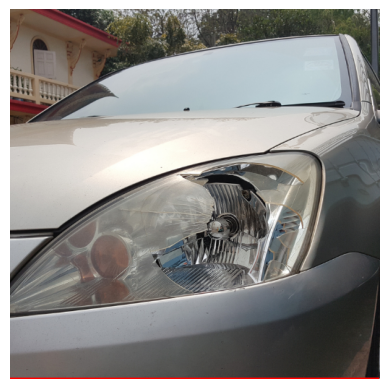

In [13]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms.functional import to_tensor, to_pil_image
import matplotlib.pyplot as plt
import torchvision.transforms as T

image_tensor = (sample[0]).to(dtype=torch.uint8)
image_tensor = image_tensor.type(torch.uint8)

print(image_tensor.shape)

masks = filtered_prediction['masks'] > 0  # Convert masks to boolean
image_with_masks = draw_segmentation_masks(image_tensor, masks.squeeze(1), colors="pink", alpha=0.7)

boxes = filtered_prediction['boxes']
labels = [classes[int(label)] for label in filtered_prediction['labels']]
image_with_boxes = draw_bounding_boxes(image_with_masks, boxes, colors="red", labels=labels, width=2)

plt.imshow(to_pil_image(image_with_boxes))
plt.axis('off')
plt.show()